<a href="https://colab.research.google.com/github/ugurcancakal/network_pytorch/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adverserial Networks in PyTorch

# Generative Adverserial Networks in PyTorch

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach: 

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. This rather simple approach can lead to some astounding results. The following images ([source](https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/)), for instances, were all generated using GANs:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-Photorealistic-Human-Faces-Generated-by-a-GAN.png" alt="gans_results" width="480">


GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of handwritten digits similar to those from the MNIST database.

<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >

Most of the code for this tutorial has been borrowed for this excellent repository of PyTorch tutorials: [github.com/yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial). Here's what we're going to do:

* Define the problem statement
* Load the data (with transforms and normalization)
    * Denormalize for visual inspection of samples
* Define the Discriminator network
    * Study the activation function: Leaky ReLU
* Define the Generator network
    * Explain the output activation function: TanH
    * Look at some sample outputs
* Define losses, optimizers and helper functions for training
    * For discriminator
    * For generator
* Train the model
    * Save intermediate generated images to file
* Look at some outputs
* Save the models

In [ ]:
# Define the problem statement
import torch
import torchvision 
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [ ]:
# Load the data (with transforms and normalization)
mnist = MNIST(root = '/data',
              train = True,
              download = True,
              transform=Compose([ToTensor(), Normalize(mean = (.5), std = (.5))]))

In [ ]:
img,label = mnist[0]
print('Label: ', label)
print(img[:,10,10:15])
print(torch.min(img), torch.max(img))

Label:  5
tensor([[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000]])
tensor(-1.) tensor(1.)


In [ ]:
# Denormalize for visual inspection of samples
def denorm(x):
  out = (x+1)/2
  return(out.clamp(0,1))

Label:  5


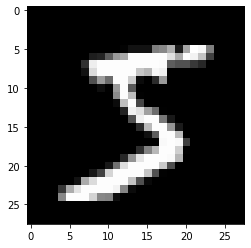

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label: ', label)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

First Batch
torch.Size([100, 1, 28, 28])
tensor([6, 5, 5, 5, 4, 7, 3, 8, 1, 2, 5, 5, 0, 9, 4, 0, 9, 4, 4, 4, 1, 5, 8, 0,
        7, 7, 6, 1, 2, 0, 6, 8, 0, 9, 8, 9, 2, 8, 0, 6, 8, 2, 8, 0, 3, 8, 5, 4,
        7, 1, 6, 4, 1, 6, 9, 1, 9, 6, 8, 7, 0, 5, 6, 9, 8, 9, 8, 5, 0, 1, 1, 8,
        9, 8, 0, 3, 4, 6, 2, 0, 3, 0, 5, 9, 7, 6, 4, 8, 3, 1, 0, 0, 0, 0, 7, 9,
        2, 2, 7, 0])


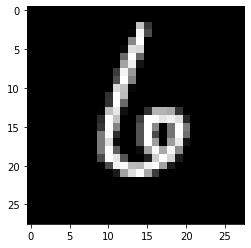

In [ ]:
for img_batch, label_batch in data_loader:
  print('First Batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0], cmap='gray')
  print(label_batch)
  break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


# Discriminator Network

Discriminator takes an image as input, and tries to classify it as **"real"** or **"generated"**. In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll trat each 28x28 image as a vector of size 784

In [ ]:
# Define the Discriminator network
    # Study the activation function: Leaky ReLU
image_size = mnist[0][0].shape[1]*mnist[0][0].shape[2]
hidden_size = 2**8

import torch.nn as nn
D = nn.Sequential(nn.Linear(image_size, hidden_size),
                  nn.LeakyReLU(.2),
                  nn.Linear(hidden_size, hidden_size),
                  nn.LeakyReLU(.2),
                  nn.Linear(hidden_size, 1),
                  nn.Sigmoid())

We use the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.

Let's move the discriminator model to the chosen device.

In [ ]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedforward neural network with 3 layers, and the output will be a vector of size 784, whic can be transformed to a 28x28 image

In [ ]:
# Define the Generator network
    # Explain the output activation function: TanH
    # Look at some sample outputs
latent_size = 64

G = nn.Sequential(nn.Linear(latent_size, hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size, hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size, image_size),
                  nn.Tanh())

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [ ]:
y = G(torch.randn(2,latent_size))
gen_imgs = denorm(y.reshape(-1,28,28).detach())


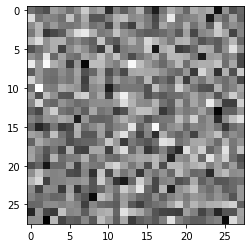

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray')

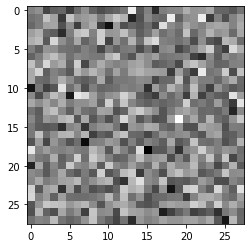

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray')

In [ ]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [ ]:
# Define losses, optimizers and helper functions for training
    # For discriminator
    # For generator

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = .0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = .0002)

In [ ]:
# Sabit batch size degistirilebilir !!
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(images):
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  # Loss for real images
  outputs  = D(images)
  d_loss_real = criterion(outputs, real_labels)
  real_score = outputs

  # Loss for fake images
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs, fake_labels)
  fake_score = outputs

  # Combine losses
  d_loss = d_loss_real + d_loss_fake
  # Reset gradients 
  reset_grad()
  # Compute gradients
  d_loss.backward()
  # Adjust the parameters using backprob
  d_optimizer.step()

  return d_loss, real_score, fake_score

# Generator Training

Since the outputs of the generator are vectors(which can be transformed to images), it's not obvious how we can **"train"** the generator. This is where we employ a rather elegant **"trick"**. Since we know that the ouput images are **"generated"** or **"fake"**, we can pass them into the discriminator, and compare the output of the discriminator with the ground truth (i.e. all fake), and use that to calculate the loss for the generator.

In other words, we the discriminator as a part of the loss funtion. Here's what this looks like in code.

In [ ]:
z = torch.rand(batch_size, latent_size).to(device)
fake_images = G(z)
D(fake_images)

tensor([[0.4833],
        [0.4816],
        [0.4827],
        [0.4820],
        [0.4826],
        [0.4825],
        [0.4828],
        [0.4821],
        [0.4818],
        [0.4821],
        [0.4827],
        [0.4821],
        [0.4833],
        [0.4823],
        [0.4828],
        [0.4820],
        [0.4826],
        [0.4826],
        [0.4825],
        [0.4826],
        [0.4824],
        [0.4828],
        [0.4826],
        [0.4827],
        [0.4815],
        [0.4827],
        [0.4825],
        [0.4816],
        [0.4827],
        [0.4829],
        [0.4827],
        [0.4835],
        [0.4811],
        [0.4833],
        [0.4821],
        [0.4817],
        [0.4825],
        [0.4829],
        [0.4836],
        [0.4822],
        [0.4826],
        [0.4819],
        [0.4829],
        [0.4834],
        [0.4828],
        [0.4826],
        [0.4828],
        [0.4824],
        [0.4835],
        [0.4824],
        [0.4822],
        [0.4827],
        [0.4822],
        [0.4824],
        [0.4836],
        [0

In [ ]:
def train_generator():
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size, 1).to(device)
  g_loss = criterion(D(fake_images),labels) # kandirdik mi kandiramadik mi
  # Generator discriminator u kandirmak istiyor
  # generator u egitirken, uretilmis resimleri gercekmis gibi degerlendirt.
  # discriminator u egitirken uretilmis resimlerin uretilmis oldugunu bilerek
  # unusual thing is that the discriminator is a part of the loss function

  # Backprop and optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

# Training the model

Let's create a directory where we can save the intermediate outputs from the generator to visually inspect the progress of the model.

In [ ]:
# Train the model
    # Save intermediate generated images to file
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

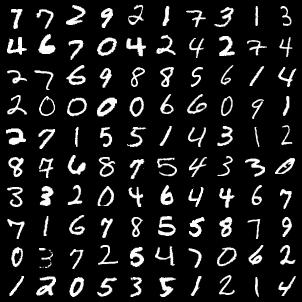

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
  images = images.reshape(images.size(0), 1, 28, 28)
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow = 10)
  break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving  fake_images-0000.png


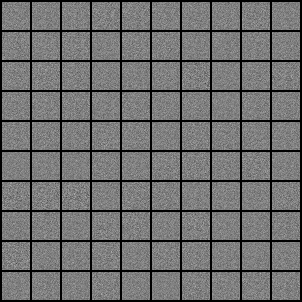

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vectors)
  fake_images = fake_images.reshape(fake_images.size(0), 1,28,28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving ', fake_fname)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)

# Before Training 
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [24]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [],[],[],[]

for epoch in range(num_epochs):
  for i, (images,_) in enumerate(data_loader):
    # Load a batch & transform to vectors
    images = images.reshape(batch_size, -1).to(device)

    # Train the discriminator and generator 
    d_loss, real_score, fake_score = train_discriminator(images)
    g_loss, fake_images = train_generator()

    # Inspect the losses
    if (i+1) % 200 == 0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
      print('Epoch [{}/{}], Step[{}/{}], \
      d_loss : {:.4f}, g_loss : {:.4f} ,\
      D(x) : {:.2f}, G(x) : {:.2f}'.format(epoch+1,num_epochs,i+1,total_step,\
                                           d_loss.item(),g_loss.item(),\
                                           real_score.mean().item(),\
                                           fake_score.mean().item()))
  save_fake_images(epoch+1)

Epoch [1/300], Step[200/600],       d_loss : 0.0349, g_loss : 4.6114 ,      D(x) : 0.99, G(x) : 0.03
Epoch [1/300], Step[400/600],       d_loss : 0.3352, g_loss : 4.7393 ,      D(x) : 0.92, G(x) : 0.12
Epoch [1/300], Step[600/600],       d_loss : 0.0385, g_loss : 5.4067 ,      D(x) : 0.99, G(x) : 0.02
Saving  fake_images-0001.png
Epoch [2/300], Step[200/600],       d_loss : 0.1495, g_loss : 3.8576 ,      D(x) : 0.94, G(x) : 0.07
Epoch [2/300], Step[400/600],       d_loss : 0.1174, g_loss : 4.5451 ,      D(x) : 0.96, G(x) : 0.06
Epoch [2/300], Step[600/600],       d_loss : 0.4639, g_loss : 3.3744 ,      D(x) : 0.85, G(x) : 0.14
Saving  fake_images-0002.png
Epoch [3/300], Step[200/600],       d_loss : 0.0762, g_loss : 4.6849 ,      D(x) : 0.98, G(x) : 0.05
Epoch [3/300], Step[400/600],       d_loss : 0.3033, g_loss : 3.4841 ,      D(x) : 0.90, G(x) : 0.08
Epoch [3/300], Step[600/600],       d_loss : 0.3531, g_loss : 3.4282 ,      D(x) : 0.88, G(x) : 0.14
Saving  fake_images-0003.png
Epoc

In [30]:
# Save the models
torch.save(G.state_dict(), 'G.chkpt')
torch.save(D.state_dict(), 'D.chkpt')

In [31]:
# Look at some outputs
import cv2
import os
from IPython.display import FileLink


files = [os.path.join(sample_dir, f) \
         for f in os.listdir(sample_dir) if 'fake_images' in f]
print(files)

['samples/fake_images-0014.png', 'samples/fake_images-0238.png', 'samples/fake_images-0088.png', 'samples/fake_images-0182.png', 'samples/fake_images-0133.png', 'samples/fake_images-0206.png', 'samples/fake_images-0257.png', 'samples/fake_images-0096.png', 'samples/fake_images-0143.png', 'samples/fake_images-0203.png', 'samples/fake_images-0297.png', 'samples/fake_images-0185.png', 'samples/fake_images-0165.png', 'samples/fake_images-0019.png', 'samples/fake_images-0140.png', 'samples/fake_images-0170.png', 'samples/fake_images-0071.png', 'samples/fake_images-0156.png', 'samples/fake_images-0042.png', 'samples/fake_images-0072.png', 'samples/fake_images-0278.png', 'samples/fake_images-0255.png', 'samples/fake_images-0296.png', 'samples/fake_images-0293.png', 'samples/fake_images-0121.png', 'samples/fake_images-0087.png', 'samples/fake_images-0035.png', 'samples/fake_images-0003.png', 'samples/fake_images-0178.png', 'samples/fake_images-0299.png', 'samples/fake_images-0164.png', 'sample

In [32]:
vid_fname = 'gans_training.avi'
out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')
# inputun cok az degismesi gerek ki anlamli bir video elde edelim

/content/gans_training.avi

# Visualizing Losses and Scores

Text(0.5, 1.0, 'Losses')

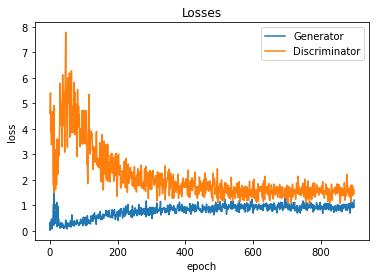

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Generator', 'Discriminator'])
plt.title('Losses')
# Discriminator is getting better but generator is getting 
# a lot more better over time. That's what we want

Text(0.5, 1.0, 'Scores')

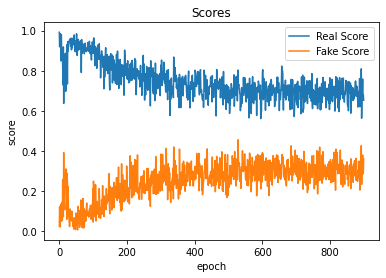

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake Score'])
plt.title('Scores')
# For perfect generator, the values need to be as closest as possible